In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
fasta = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa'

In [3]:
%%bash

head -n1 /projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa

>1 dna:chromosome chromosome:GRCh38:1:1:248956422:1 REF


# Load peak files to analyze

In [4]:
from glob import glob

In [5]:
files_to_check = glob('6_overlapped_confident_peaks/*RBFOX*')

In [6]:
filtered_files_to_check = []
for f in files_to_check:
    if '0078' in f and 'both' in f:
        filtered_files_to_check.append(f)
    elif 'ct' in f and 'APO' in f:
        filtered_files_to_check.append(f)
    elif 'ai' in f and ('8e' in f or 'MinA' in f):
        filtered_files_to_check.append(f)


In [7]:
from pyfaidx import Fasta

complements = {
    'A': 'T',
    'T': 'A',
    'C': 'G',
    'G': 'C'
}

def reverse_complement(s):
    s = s.upper()
    new_s = ''
    
    for character in reversed(s):
        new_s = new_s + complements.get(character)
    return new_s


def get_sequence(fasta_obj, chrom, start, end, strand):
    sequence = str(fasta_obj[chrom][start:end])
    if strand == '-':
        sequence = reverse_complement(sequence)
    return sequence
    
fasta_obj = Fasta(fasta)

lengths = {}

for f in filtered_files_to_check:
    filename = f.split('/')[-1].split('.tsv')[0]
    print(filename)
    df = pd.read_csv(f, sep='\t', index_col=0)

    sequences = {}
    for r in df.iterrows():
        r = r[1]
        chrom = r.chrom
        start = r.start
        end = r.end
        strand = r.strand
        label = r.label

        sequence = get_sequence(fasta_obj, chrom, start, end, strand)
        sequences[label] = sequence
    sequence_df = pd.DataFrame(pd.DataFrame(sequences, index=sequences.keys()).iloc[0])
    sequence_df.columns = ['sequence']
    
    sequence_df.to_csv('6.2_peaks_with_sequences/{}.tsv'.format(filename), sep='\t', index=True)
    
    lengths[filename] = [int(i.split(":")[1].split('(')[0].split('-')[1]) -  int(i.split(":")[1].split('(')[0].split('-')[0]) for i in sequence_df.index]


RBFOX2_ai_FOX2-8e_cleaned
RBFOX2_both_FOX2-P0078
RBFOX2_ai_FOX2-MinA
RBFOX2_ct_APOBEC1_alone
RBFOX2_ai_MinA_alone
RBFOX2_ct_FOX2-APOBEC1_cleaned
RBFOX2_both_P0078_alone
RBFOX2_both_FOX2-P0078_cleaned
RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-MinA_cleaned
RBFOX2_ct_FOX2-APOBEC1
RBFOX2_ai_8e_alone


In [8]:
len(lengths.get('RBFOX2_ct_FOX2-APOBEC1')), len((lengths.get('RBFOX2_ai_FOX2-8e')))

(2257, 9402)

# GC-content

In [9]:
label_to_df = {}
for f in glob('6.2_peaks_with_sequences/*'):
    df = pd.read_csv(f, sep='\t', index_col=0)
    name = f.split('/')[-1].split('.tsv')[0]
    label_to_df[name] = df

In [10]:
def get_gc_content(s):
    num_g = s.count('G')
    num_c = s.count('C')
    num_at = len(s) - (num_g + num_c)
    assert(num_g + num_c + num_at == len(s))
    return (num_g + num_c) / len(s)

def get_a_content(s):
    num_a = s.count('A')
    return (num_a) / len(s)

def get_t_content(s):
    num_t = s.count('T')
    return (num_t) / len(s)

def get_c_content(s):
    num_c = s.count('C')
    return (num_c) / len(s)

def get_g_content(s):
    num_g = s.count('G')
    return (num_g) / len(s)

In [11]:
label_to_df_with_gc_content = {}
for label, df in label_to_df.items():
    df['GC_content'] = df.sequence.apply(get_gc_content)
    df['A_content'] = df.sequence.apply(get_a_content)
    df['T_content'] = df.sequence.apply(get_t_content)
    df['C_content'] = df.sequence.apply(get_c_content)
    df['G_content'] = df.sequence.apply(get_g_content)

    label_to_df_with_gc_content[label] = df

"\n### and now for each enzyme\nfor enzyme in ['APO', '78', 'MinA', '8e']:\n    plt.figure(figsize=(15, 4))\n    legend = []\n    for label in sorted(label_to_df_with_gc_content.keys()):\n        df = label_to_df_with_gc_content.get(label)\n        if enzyme in label:\n            sns.distplot(df.GC_content, hist=False).set(yticklabels=[], yticks=[])\n            legend.append(label)\n    plt.legend(legend)\n    plt.title(enzyme)\n    plt.savefig('images/svgs/flanking_region_plots/{}_peaks_gc_content.svg'.format(enzyme))\n"

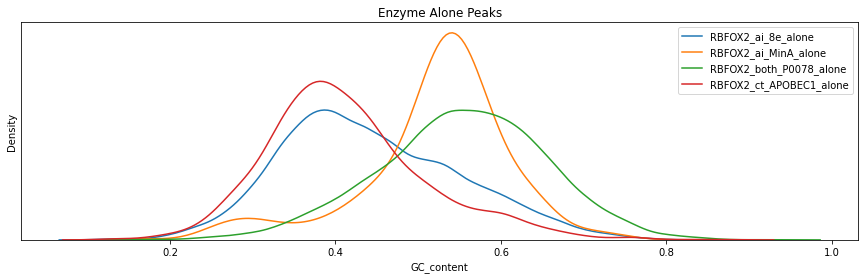

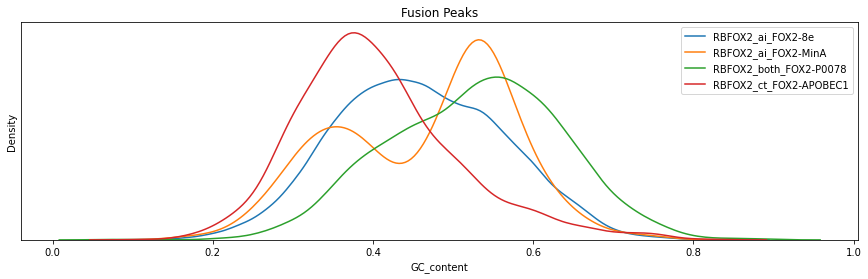

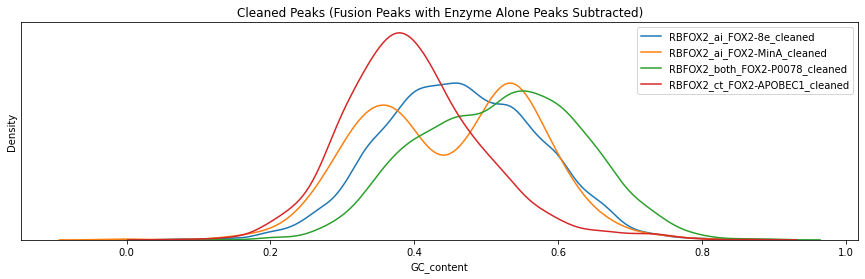

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))
legend = []
for label in sorted(label_to_df_with_gc_content.keys()):
    df = label_to_df_with_gc_content.get(label)
    if 'alone' in label:
        sns.distplot(df.GC_content, hist=False).set(yticklabels=[], yticks=[])
        legend.append(label)
plt.legend(legend)
plt.title("Enzyme Alone Peaks")
plt.savefig('images/svgs/flanking_region_plots/enzyme_alone_peaks_gc_content.svg')

plt.figure(figsize=(15, 4))
legend = []
for label in sorted(label_to_df_with_gc_content.keys()):
    df = label_to_df_with_gc_content.get(label)
    if 'cleaned' not in label and 'alone' not in label:
        sns.distplot(df.GC_content, hist=False).set(yticklabels=[], yticks=[])
        legend.append(label)
plt.legend(legend)
plt.title("Fusion Peaks")
plt.savefig('images/svgs/flanking_region_plots/fusion_peaks_gc_content.svg')

plt.figure(figsize=(15, 4))
legend = []
for label in sorted(label_to_df_with_gc_content.keys()):
    df = label_to_df_with_gc_content.get(label)
    if 'cleaned' in label:
        sns.distplot(df.GC_content, hist=False).set(yticklabels=[], yticks=[])
        legend.append(label)
plt.legend(legend)
plt.title("Cleaned Peaks (Fusion Peaks with Enzyme Alone Peaks Subtracted)")
plt.savefig('images/svgs/flanking_region_plots/cleaned_peaks_gc_content.svg')


"""
### and now for each enzyme
for enzyme in ['APO', '78', 'MinA', '8e']:
    plt.figure(figsize=(15, 4))
    legend = []
    for label in sorted(label_to_df_with_gc_content.keys()):
        df = label_to_df_with_gc_content.get(label)
        if enzyme in label:
            sns.distplot(df.GC_content, hist=False).set(yticklabels=[], yticks=[])
            legend.append(label)
    plt.legend(legend)
    plt.title(enzyme)
    plt.savefig('images/svgs/flanking_region_plots/{}_peaks_gc_content.svg'.format(enzyme))
"""

In [13]:
label_to_df_with_gc_content.keys()

dict_keys(['RBFOX2_ai_FOX2-8e_cleaned', 'RBFOX2_both_FOX2-P0078', 'RBFOX2_ai_FOX2-MinA', 'RBFOX2_ct_APOBEC1_alone', 'RBFOX2_ai_MinA_alone', 'RBFOX2_ct_FOX2-APOBEC1_cleaned', 'RBFOX2_both_P0078_alone', 'RBFOX2_both_FOX2-P0078_cleaned', 'RBFOX2_ai_FOX2-8e', 'RBFOX2_ai_FOX2-MinA_cleaned', 'RBFOX2_ct_FOX2-APOBEC1', 'RBFOX2_ai_8e_alone'])

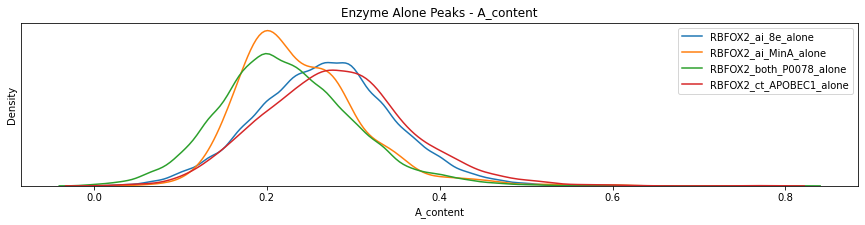

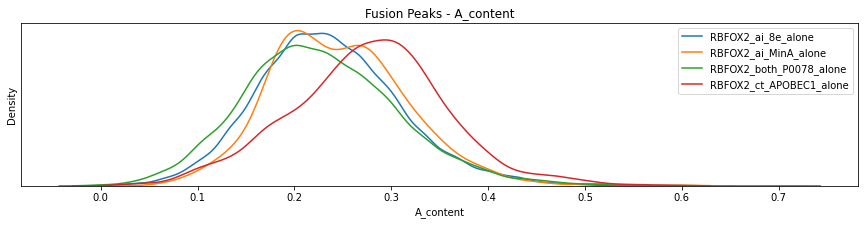

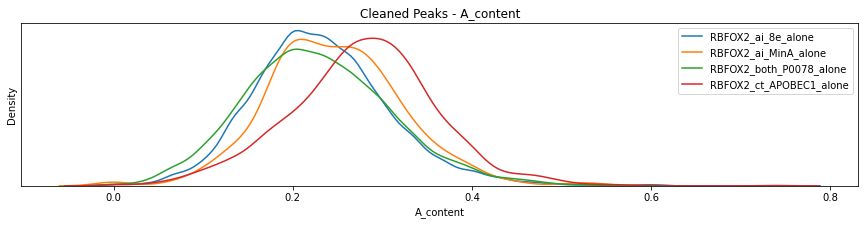

In [14]:
legend = []

for trait in ['A_content']:#, 'T_content', 'C_content', 'G_content', 'GC_content']:
    plt.figure(figsize=(15, 3))
    for label in sorted(label_to_df_with_gc_content.keys()):
        df = label_to_df_with_gc_content.get(label)
        if 'alone' in label:
            sns.distplot(df[trait], hist=False).set(yticklabels=[], yticks=[])
            legend.append(label)
        plt.legend(legend)
        plt.title("Enzyme Alone Peaks - {}".format(trait))

plt.savefig('images/svgs/flanking_region_plots/enzyme_alone_peaks_a_content.svg')

for trait in ['A_content']:#, 'T_content', 'C_content', 'G_content', 'GC_content']:
    plt.figure(figsize=(15, 3))
    for label in sorted(label_to_df_with_gc_content.keys()):
        df = label_to_df_with_gc_content.get(label)
        if 'alone' not in label and 'cleaned' not in label:
            sns.distplot(df[trait], hist=False).set(yticklabels=[], yticks=[])
            legend.append(label)
        plt.legend(legend)
        plt.title("Fusion Peaks - {}".format(trait))
plt.savefig('images/svgs/flanking_region_plots/fusion_peaks_a_content.svg')


for trait in ['A_content']:#, 'T_content', 'C_content', 'G_content', 'GC_content']:
    plt.figure(figsize=(15, 3))
    for label in sorted(label_to_df_with_gc_content.keys()):
        df = label_to_df_with_gc_content.get(label)
        if 'alone' not in label and 'cleaned' in label:
            sns.distplot(df[trait], hist=False).set(yticklabels=[], yticks=[])
            legend.append(label)
        plt.legend(legend)
        plt.title("Cleaned Peaks - {}".format(trait))
plt.savefig('images/svgs/flanking_region_plots/cleaned_peaks_a_content.svg')


# Flanking bases on sites

### Load Metadata

In [15]:
sample_info_df = pd.read_excel('../FullRBPsWithEnzymes/Hugo_Samples_IDs.xlsx')
sample_info_df = sample_info_df.dropna()

id_to_label = {}

for r in sample_info_df.iterrows():
    r = r[1]
    
    label = r.Construct
    sample_id = r.Sample.replace('_', '-')
    
    if 'SLBP' not in label and 'RPS2' not in label:
        id_to_label[sample_id] = label
id_to_label

{'Hugo-A1': 'FOX2-APOBEC1_R1',
 'Hugo-A2': 'FOX2-APOBEC1_R2',
 'Hugo-A3': 'FOX2-APOBEC1_R3',
 'Hugo-B2': 'FOX2-p0078_R1',
 'Hugo-B3': 'FOX2-P0078_R2',
 'Hugo-B4': 'FOX2-P0078_R3',
 'Hugo-B5': 'FOX2-8e_R1',
 'Hugo-B6': 'FOX2-8e_R2',
 'Hugo-B7': 'FOX2-8e_R3',
 'Hugo-D4': 'APOBEC1_alone_R1',
 'Hugo-D5': 'APOBEC1_alone_R2',
 'Hugo-D6': 'APOBEC1_alone_R3',
 'Hugo-D7': '8e_alone_R1',
 'Hugo-D8': '8e_alone_R2',
 'Hugo-E1': '8e_alone_R3',
 'Hugo-E2': 'p0078_alone_R1',
 'Hugo-E3': 'p0078_alone_R2',
 'Hugo-E4': 'p0078_alone_R3',
 'Hugo-E5': 'MinA_alone_R1',
 'Hugo-E6': 'MinA_alone_R2',
 'Hugo-E7': 'MinA_alone_R3',
 'Hugo-E8': 'FOX2-MinA_R1',
 'Hugo-F1': 'FOX2-MinA_R2',
 'Hugo-F2': 'FOX2-MinA_R3'}

In [16]:
from glob import glob
from collections import defaultdict

label_to_sailor_outfile_ct = defaultdict()

# sailor edits
sailor_outs_ct = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs/*.bed')
# bams and bw
fwd_bw_ct = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs/8_bw_and_bam/*fwd*.bw')
rev_bw_ct = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs/8_bw_and_bam/*rev*.bw')
final_bam_ct =  glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs/8_bw_and_bam/*sorted.bam')

labels_present = []
for f in sailor_outs_ct:
    sample_id = f.split('/')[-1].split('Aligned')[0]
    try:
        label = id_to_label[sample_id]
        labels_present.append(label)
        label_to_sailor_outfile_ct[label] = pd.read_csv(f, sep='\t', names=['chrom', 'start', 'end', 'score', 'coverage', 'strand'])
    except Exception as e:
        print(e)
        
from glob import glob
from collections import defaultdict

label_to_sailor_outfile_ai = defaultdict(lambda:{})




# sailor edits
sailor_outs_ai = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs_ai/*.bed')
# bams and bw
fwd_bw_ai = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs_ai/8_bw_and_bam/*fwd*.bw')
rev_bw_ai = glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs_ai/8_bw_and_bam/*rev*.bw')
final_bam_ai =  glob('/projects/ps-yeolab4/ekofman/Hugo/RBFOX2_sailor_outs_ai/8_bw_and_bam/*sorted.bam')

labels_present = []
for f in sailor_outs_ai:
    sample_id = f.split('/')[-1].split('Aligned')[0]
    try:
        label = id_to_label[sample_id]
        labels_present.append(label)
        label_to_sailor_outfile_ai[label] = pd.read_csv(f, sep='\t', names=['chrom', 'start', 'end', 'score', 'coverage', 'strand'])
    except Exception as e:
        print(e)



In [17]:
score_filter = .9

to_keep = {}

for k, v in label_to_sailor_outfile_ct.items():
    v = v[v.score > score_filter]
    v = v[v.chrom.isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
                      '18', '19', '20', 'X', 'Y'
                      ])]
    if 'APO' in k or '78' in k:
        to_keep['{}_CT'.format(k.replace('p0078', 'P0078'))] = v
for k, v in label_to_sailor_outfile_ai.items():
    v = v[v.score > score_filter]
    v = v[v.chrom.isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
                  '18', '19', '20', 'X', 'Y'
                  ])]
    if 'MinA' in k or '8e' in k or '78' in k:
        to_keep['{}_AI'.format(k.replace('p0078', 'P0078'))] = v

In [18]:
for k, v in to_keep.items():
    if '78' in k and 'CT' in k:
        print(k.split('_CT')[0])
        
for label_78 in [
    'P0078_alone_R3',
    'FOX2-P0078_R3',
    'P0078_alone_R1',
    'FOX2-P0078_R1',
    'FOX2-P0078_R2',
    'P0078_alone_R2'
]:
    ct_df = to_keep.get('{}_CT'.format(label_78))
    ai_df = to_keep.get('{}_AI'.format(label_78))
    combined_df = pd.concat([ct_df, ai_df])
    to_keep['{}_both'.format(label_78)] = combined_df
    del to_keep['{}_CT'.format(label_78)]
    del to_keep['{}_AI'.format(label_78)]

FOX2-P0078_R3
P0078_alone_R2
P0078_alone_R1
P0078_alone_R3
FOX2-P0078_R2
FOX2-P0078_R1


In [19]:
total_apo = [int(v.split(',')[1]) for v in to_keep.get('FOX2-APOBEC1_R1_CT').coverage]
edited_apo = [int(v.split(',')[0]) for v in to_keep.get('FOX2-APOBEC1_R1_CT').coverage]

In [20]:
total_8e = [int(v.split(',')[1]) for v in to_keep.get('FOX2-8e_R3_AI').coverage]
edited_8e = [int(v.split(',')[0]) for v in to_keep.get('FOX2-8e_R3_AI').coverage]

In [21]:
frac_apo = []
for e,t in zip(edited_apo, total_apo):
    frac_apo.append(e/t)
frac_8e = []
for e,t in zip(edited_8e, total_8e):
    frac_8e.append(e/t)

In [22]:
flank_num = 1
def add_flanking_sequence(r):
    chrom = r.chrom
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = str(get_sequence(fasta_obj, chrom, start-flank_num, end+flank_num, strand))
    return sequence

def add_only_flanking_sequence(r):
    chrom = r.chrom
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = str(get_sequence(fasta_obj, chrom, start-flank_num, end+flank_num, strand))
    #return sequence[0] + sequence[1] + sequence[3] + sequence[4]
    return sequence[0] + sequence[2] 

def add_center_base(r):
    chrom = r.chrom
    start = r.start
    end = r.end
    strand = r.strand
    
    sequence = str(get_sequence(fasta_obj, chrom, start-flank_num, end+flank_num, strand))
    #return sequence[2]
    return sequence[1]

In [23]:
to_keep_with_sequence = {}

for label, df in to_keep.items():
    print(label)

    df['flanking'] = df.apply(add_only_flanking_sequence, axis=1)
    df['sequence'] = df.apply(add_flanking_sequence, axis=1)
    df['center'] = df.apply(add_center_base, axis=1)

    to_keep_with_sequence[label] = df

FOX2-APOBEC1_R1_CT
APOBEC1_alone_R3_CT
FOX2-APOBEC1_R3_CT
FOX2-APOBEC1_R2_CT
APOBEC1_alone_R2_CT
APOBEC1_alone_R1_CT
8e_alone_R3_AI
FOX2-MinA_R3_AI
FOX2-8e_R3_AI
8e_alone_R1_AI
8e_alone_R2_AI
MinA_alone_R1_AI
FOX2-MinA_R2_AI
MinA_alone_R2_AI
FOX2-8e_R1_AI
FOX2-8e_R2_AI
FOX2-MinA_R1_AI
MinA_alone_R3_AI
P0078_alone_R3_both
FOX2-P0078_R3_both
P0078_alone_R1_both
FOX2-P0078_R1_both
FOX2-P0078_R2_both
P0078_alone_R2_both


In [24]:
for label, df in to_keep_with_sequence.items():
    print(label)
    print('\t\t', df.groupby('center').count()[['chrom']])

FOX2-APOBEC1_R1_CT
		         chrom
center       
C       44015
APOBEC1_alone_R3_CT
		         chrom
center       
C       24386
FOX2-APOBEC1_R3_CT
		         chrom
center       
C       39205
FOX2-APOBEC1_R2_CT
		         chrom
center       
C       47754
APOBEC1_alone_R2_CT
		         chrom
center       
C       45878
APOBEC1_alone_R1_CT
		         chrom
center       
C       42923
8e_alone_R3_AI
		          chrom
center        
A       104635
FOX2-MinA_R3_AI
		         chrom
center       
A       11352
FOX2-8e_R3_AI
		         chrom
center       
A       62670
8e_alone_R1_AI
		         chrom
center       
A       95839
8e_alone_R2_AI
		         chrom
center       
A       81139
MinA_alone_R1_AI
		         chrom
center       
A       13438
FOX2-MinA_R2_AI
		         chrom
center       
A       23323
MinA_alone_R2_AI
		         chrom
center       
A       17551
FOX2-8e_R1_AI
		         chrom
center       
A       65130
FOX2-8e_R2_AI
		         chrom
center       
A       94963
FOX2-Mi

# Kmer distribution

In [25]:
all_counts = []
for label, df in to_keep_with_sequence.items():
    counts = to_keep_with_sequence.get(label).groupby('flanking').count()[['chrom']]
    counts.columns = [label]
    all_counts.append(counts)

In [26]:
flanking_combined_df = pd.concat(all_counts, axis=1)

In [27]:
flanking_combined_df = flanking_combined_df.fillna(0)

In [28]:
flanking_combined_df = (flanking_combined_df/flanking_combined_df.sum()).T

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pcs = ['PC1', 'PC2', 'PC3', 'PC4']
x = StandardScaler().fit_transform(flanking_combined_df)
pca = PCA(n_components=len(pcs))
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = pcs)
principalDf.index = flanking_combined_df.index

In [30]:
var_explained = pd.DataFrame(pca.explained_variance_ratio_, pcs)

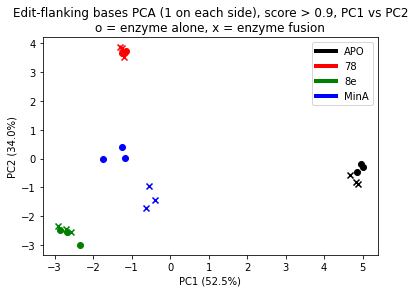

In [31]:
from matplotlib.lines import Line2D

color_map = {
    'APO': 'black',
    '78': 'red',
    '8e': 'green',
    'MinA': 'blue'
}

shape_map = {
    'alone': 'o',
    'fusion': 'x'
}


custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)


pc_comps = [['PC1', 'PC2']]
for pc_comp in pc_comps:
    plt.figure()
    for r in principalDf.iterrows():
        pc_x = r[1][pc_comp[0]]
        pc_y = r[1][pc_comp[1]]
    
        label = r[0]

        for key, value in color_map.items():
            if key in label:
                color = value
                continue

        if 'alone' in label:
            shape = shape_map.get('alone')
        else:
            shape = shape_map.get('fusion')
        plt.scatter(pc_x, pc_y, color=color, marker=shape)
        
    x_var = round(float(var_explained.loc[pc_comp[0]]), 3) * 100
    y_var = round(float(var_explained.loc[pc_comp[1]]), 3) * 100

    plt.xlabel('{} ({}%)'.format(pc_comp[0], x_var))
    plt.ylabel('{} ({}%)'.format(pc_comp[1], y_var))
    plt.title("Edit-flanking bases PCA ({} on each side), score > {}, {} vs {}\no = enzyme alone, x = enzyme fusion".format(flank_num,
                                                                                                                            score_filter,
                                                                                                                           pc_comp[0], 
                                                                                                                           pc_comp[1]))
    plt.legend(custom_lines, legend)
    plt.savefig('images/svgs/flanking_region_plots/edit_{}_flanking_bases_pca_score_gt_{}.svg'.format(flank_num, score_filter))


In [32]:
loadings = pd.DataFrame(pca.components_.T, columns=pcs, index=flanking_combined_df.columns)

In [33]:
def get_gc_content(r):
    kmer = r.name
    return (kmer.count('G') + kmer.count('C'))/len(kmer)
    
def get_at_content(r):
    kmer = r.name
    return (kmer.count('A') + kmer.count('T'))/len(kmer)

def get_t_content(r):
    kmer = r.name
    return (kmer.count('T'))/len(kmer)

def get_a_content(r):
    kmer = r.name
    return (kmer.count('A'))/len(kmer)

def get_g_content(r):
    kmer = r.name
    return (kmer.count('G'))/len(kmer)

def get_c_content(r):
    kmer = r.name
    return (kmer.count('C'))/len(kmer)

loadings['GC content'] = loadings.apply(get_gc_content, axis=1)

loadings['A content'] = loadings.apply(get_a_content, axis=1)
loadings['C content'] = loadings.apply(get_c_content, axis=1)
loadings['T content'] = loadings.apply(get_t_content, axis=1)
loadings['G content'] = loadings.apply(get_g_content, axis=1)


In [34]:
pc_correlations = loadings.corr().loc[['PC1', 'PC2']][['GC content', 'A content', 'C content', 'T content', 'G content']]

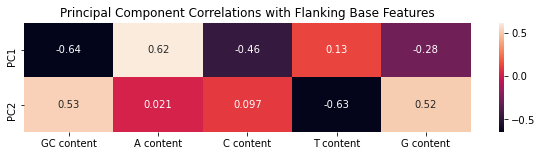

In [35]:
plt.figure(figsize=(10, 2))
sns.heatmap(pc_correlations, annot=True)
plt.title("Principal Component Correlations with Flanking Base Features")
plt.savefig("images/svgs/flanking_region_plots/pc_corr_with_{}_flanking_base_features_score_gt_{}.svg".format(
    flank_num,
    score_filter))

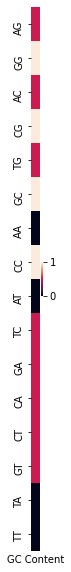

In [36]:
import seaborn as sns

plt.figure(figsize=(.2, 10))
sns.heatmap(pd.DataFrame(loadings.sort_values('PC2', ascending=False)['GC content']))
plt.ylabel('')
plt.xlabel("GC Content")
plt.savefig("images/svgs/flanking_region_plots/pc2_gc_content_score_gt_{}_{}.svg".format(score_filter, flank_num))

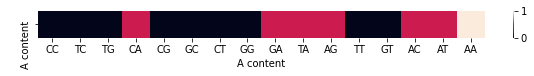

In [37]:
plt.figure(figsize=(10, .5))
sns.heatmap(pd.DataFrame(loadings.sort_values('PC1')['A content']).T)
plt.xlabel('A content')
plt.ylabel(' ')
plt.savefig("images/svgs/flanking_region_plots/pc1_a_content_score_gt_{}_{}.svg".format(score_filter, flank_num))

# Top contexts per enzyme

In [38]:
num_vals = 2
flanking_combined_df_most_informative = flanking_combined_df[list(set(list(loadings.sort_values('PC2').head(num_vals).index) + 
                     list(loadings.sort_values('PC2').tail(num_vals).index) + 
                     list(loadings.sort_values('PC1').head(num_vals).index) + 
                     list(loadings.sort_values('PC1').tail(num_vals).index) 
                     #list(loadings.sort_values('PC3').head(num_vals).index) + 
                     #list(loadings.sort_values('PC3').tail(num_vals).index)
                             ))
                    ]

In [39]:
flanking_combined_df_most_informative = flanking_combined_df_most_informative.loc[
    ['8e_alone_R1_AI', '8e_alone_R2_AI', '8e_alone_R3_AI',
     'FOX2-8e_R1_AI', 'FOX2-8e_R2_AI', 'FOX2-8e_R3_AI',
     'APOBEC1_alone_R1_CT', 'APOBEC1_alone_R2_CT', 'APOBEC1_alone_R3_CT',
     'FOX2-APOBEC1_R1_CT', 'FOX2-APOBEC1_R2_CT', 'FOX2-APOBEC1_R3_CT',
     'MinA_alone_R1_AI','MinA_alone_R2_AI', 'MinA_alone_R3_AI',
         'FOX2-MinA_R1_AI', 'FOX2-MinA_R2_AI', 'FOX2-MinA_R3_AI', 
     'P0078_alone_R1_both','P0078_alone_R2_both', 'P0078_alone_R3_both',
     'FOX2-P0078_R1_both','FOX2-P0078_R2_both', 'FOX2-P0078_R3_both']
]

In [40]:
flanking_combined_df_most_informative = flanking_combined_df_most_informative.T

In [41]:
flanking_combined_df_most_informative['8e_alone'] = flanking_combined_df_most_informative[
    ['8e_alone_R1_AI', '8e_alone_R2_AI', '8e_alone_R3_AI']].mean(axis=1)
flanking_combined_df_most_informative['FOX2-8e'] = flanking_combined_df_most_informative[
    ['FOX2-8e_R1_AI', 'FOX2-8e_R2_AI', 'FOX2-8e_R3_AI']].mean(axis=1)

flanking_combined_df_most_informative['APOBEC1_alone'] = flanking_combined_df_most_informative[
    ['APOBEC1_alone_R1_CT', 'APOBEC1_alone_R2_CT', 'APOBEC1_alone_R3_CT']].mean(axis=1)
flanking_combined_df_most_informative['FOX2-APOBEC1'] = flanking_combined_df_most_informative[
    ['FOX2-APOBEC1_R1_CT', 'FOX2-APOBEC1_R2_CT', 'FOX2-APOBEC1_R3_CT']].mean(axis=1)

flanking_combined_df_most_informative['MinA_alone'] = flanking_combined_df_most_informative[
    ['MinA_alone_R1_AI','MinA_alone_R2_AI', 'MinA_alone_R3_AI']].mean(axis=1)
flanking_combined_df_most_informative['FOX2-MinA'] = flanking_combined_df_most_informative[
    ['FOX2-MinA_R1_AI', 'FOX2-MinA_R2_AI', 'FOX2-MinA_R3_AI']].mean(axis=1)

flanking_combined_df_most_informative['P0078_alone'] = flanking_combined_df_most_informative[
    ['P0078_alone_R1_both','P0078_alone_R2_both', 'P0078_alone_R3_both']].mean(axis=1)
flanking_combined_df_most_informative['FOX2-P0078'] = flanking_combined_df_most_informative[
    ['FOX2-P0078_R1_both','FOX2-P0078_R2_both', 'FOX2-P0078_R3_both']].mean(axis=1)




In [42]:
flanking_combined_df_most_informative_means = flanking_combined_df_most_informative[
    [c for c in flanking_combined_df_most_informative.columns if '_R' not in c]].T

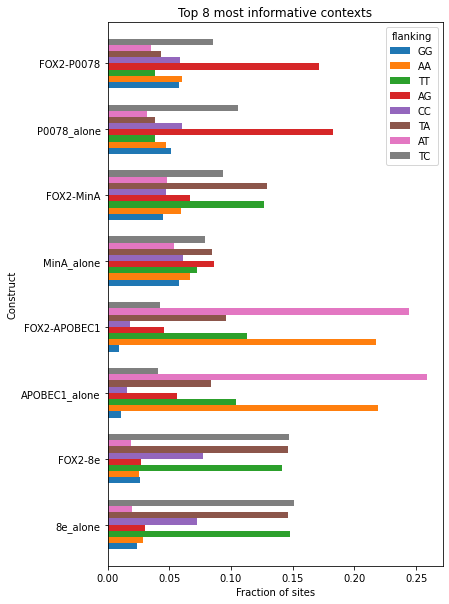

In [43]:
flanking_combined_df_most_informative_means.plot(kind='barh', figsize=(6, 10), width=.75)
plt.xlabel("Fraction of sites")
plt.ylabel("Construct")
plt.title("Top {} most informative contexts".format(num_vals*4))
plt.savefig("images/svgs/flanking_region_plots/top_contexts_for_enzymes_score_gt_{}_{}.svg".format(score_filter, flank_num))

In [44]:
num_vals = 50
flanking_combined_df_most_informative = flanking_combined_df[list(set(list(loadings.sort_values('PC2').head(num_vals).index) + 
                     list(loadings.sort_values('PC2').tail(num_vals).index) + 
                     list(loadings.sort_values('PC1').head(num_vals).index) + 
                     list(loadings.sort_values('PC1').tail(num_vals).index) 
                     #list(loadings.sort_values('PC3').head(num_vals).index) + 
                     #list(loadings.sort_values('PC3').tail(num_vals).index)
                             ))
                    ]

flanking_combined_df_most_informative = flanking_combined_df_most_informative.T
flanking_combined_df_most_informative_means = flanking_combined_df_most_informative[
    [c for c in flanking_combined_df_most_informative.columns if '_R' not in c]].T

In [45]:
informative_columns = sorted(list(flanking_combined_df_most_informative_means.columns))

In [46]:
biflank = [c[1:3] for c in informative_columns]

In [47]:
informative_columns = sorted(list(set(biflank)))

In [48]:
len(informative_columns)

4

# Random Forest

In [904]:

all_sites = []

for label, df in to_keep_with_sequence.items():
    print(label)
    if 'alone' in label:
        df['status'] = 'alone'
    else:
        df['status'] = 'fusion'
    
    for enzyme in ['APO', '8e', '78', 'MinA']:
        if enzyme in label:
            df['enzyme'] = enzyme
            continue
            
    for enzyme in ['APO', '8e', '78', 'MinA']:
        df['is_{}'.format(enzyme)] = [e == enzyme for e in df.enzyme]
    
    df['biflank'] = [f[1:3] for f in df.flanking]
    
    for i in informative_columns:
        df[i] = i == df['biflank']
    
    df.index = df.flanking
    df['GC content'] = df.apply(get_gc_content, axis=1)
    df['A content'] = df.apply(get_a_content, axis=1)
    df['C content'] = df.apply(get_c_content, axis=1)
    df['T content'] = df.apply(get_t_content, axis=1)
    df['G content'] = df.apply(get_g_content, axis=1)
    df.index = range(len(df))
    
    df_new = df[['flanking', 'GC content',
       'A content', 'C content', 'T content', 'G content',
   'status', 'enzyme', 'is_APO', 'is_8e', 'is_78', 'is_MinA'] + informative_columns]
    
    all_sites.append(df_new)

FOX2-APOBEC1_R2_CT
APOBEC1_alone_R2_CT
APOBEC1_alone_R1_CT
APOBEC1_alone_R3_CT
FOX2-APOBEC1_R3_CT
FOX2-APOBEC1_R1_CT
MinA_alone_R2_AI
FOX2-MinA_R3_AI
FOX2-8e_R2_AI
8e_alone_R2_AI
8e_alone_R1_AI
8e_alone_R3_AI
FOX2-8e_R3_AI
MinA_alone_R3_AI
FOX2-8e_R1_AI
FOX2-MinA_R2_AI
MinA_alone_R1_AI
FOX2-MinA_R1_AI
P0078_alone_R3_both
FOX2-P0078_R3_both
P0078_alone_R1_both
FOX2-P0078_R1_both
FOX2-P0078_R2_both
P0078_alone_R2_both


In [905]:
all_sites_with_info = pd.concat(all_sites)

In [906]:
all_sites_with_info

,flanking,GC content,A content,C content,T content,G content,status,enzyme,is_APO,is_8e,...,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
0,GACT,0.50,0.25,0.25,0.25,0.25,fusion,APO,True,False,...,False,False,False,False,False,False,False,False,False,False
1,AACC,0.50,0.50,0.50,0.00,0.00,fusion,APO,True,False,...,False,False,False,False,False,False,False,False,False,False
2,CCGT,0.75,0.00,0.50,0.25,0.25,fusion,APO,True,False,...,True,False,False,False,False,False,False,False,False,False
3,GGCA,0.75,0.25,0.25,0.00,0.50,fusion,APO,True,False,...,False,False,False,True,False,False,False,False,False,False
4,CTAT,0.25,0.25,0.25,0.50,0.00,fusion,APO,True,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79420,GCCG,1.00,0.00,0.50,0.00,0.50,alone,78,False,False,...,False,False,False,False,False,False,False,False,False,False
79421,GCGG,1.00,0.00,0.25,0.00,0.75,alone,78,False,False,...,True,False,False,False,False,False,False,False,False,False
79422,ACGG,0.75,0.25,0.25,0.00,0.50,alone,78,False,False,...,True,False,False,False,False,False,False,False,False,False
79423,CCGG,1.00,0.00,0.50,0.00,0.50,alone,78,False,False,...,True,False,False,False,False,False,False,False,False,False


In [907]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

labels_overall = np.array(all_sites_with_info['enzyme'])
labels_apo = np.array(all_sites_with_info['is_APO'])
labels_8e = np.array(all_sites_with_info['is_8e'])
labels_mina = np.array(all_sites_with_info['is_MinA'])
labels_78 = np.array(all_sites_with_info['is_78'])


fusion_labels = np.array(all_sites_with_info['status'])


features= all_sites_with_info.drop(['status', 'enzyme', 'is_APO', 'is_8e', 'is_78', 'is_MinA'], axis=1)
features_no_flanking = all_sites_with_info.drop(['status', 'enzyme', 'flanking', 'is_APO', 'is_8e', 'is_78', 'is_MinA'], axis=1)

feature_list = list(features.columns)
feature_list_no_flanking = list(features_no_flanking.columns)

features = np.array(features)
features_no_flanking = np.array(features_no_flanking)

In [908]:
feature_list_no_flanking

['GC content',
 'A content',
 'C content',
 'T content',
 'G content',
 'AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT']

In [909]:
features_no_flanking

array([[0.5, 0.25, 0.25, ..., False, False, False],
       [0.5, 0.5, 0.5, ..., False, False, False],
       [0.75, 0.0, 0.5, ..., False, False, False],
       ...,
       [0.75, 0.25, 0.25, ..., False, False, False],
       [1.0, 0.0, 0.5, ..., False, False, False],
       [0.75, 0.25, 0.25, ..., False, False, False]], dtype=object)

In [910]:
# Split the data into training and testing sets
which = {
    '8e': labels_8e,
    'APO': labels_apo,
    'MinA': labels_mina,
    '78': labels_78
}

saved_predictions = {}

for enzyme, labels in which.items():
    print(enzyme)
    train_features, test_features, train_labels, test_labels = train_test_split(features_no_flanking, labels, test_size = 0.25, random_state = 42)
    rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
    print('fitting...')
    rf.fit(train_features, train_labels);
    print('predicting...')
    predictions = rf.predict(test_features)
    
    saved_predictions[enzyme] = predictions


8e
fitting...
predicting...
APO
fitting...
predicting...
MinA
fitting...
predicting...
78
fitting...
predicting...


In [911]:
train_features, test_features, train_labels, test_labels = train_test_split(features_no_flanking, labels_overall, test_size = 0.25, random_state = 42)


In [912]:
results = pd.concat([pd.DataFrame(test_features), 
                     pd.DataFrame(test_labels), 
                     pd.DataFrame(saved_predictions.get('8e')),
                     pd.DataFrame(saved_predictions.get('APO')),
                     pd.DataFrame(saved_predictions.get('MinA')),
                     pd.DataFrame(saved_predictions.get('78'))
                    ], axis=1)
results.columns = feature_list_no_flanking + ['actual', 'score_8e', 'score_APO', 'score_MinA', 'score_78']

In [913]:
import numpy as np

def assign_final_guess(r):
    max_score = np.max([r.score_8e, r.score_APO, r.score_MinA, r.score_78])
    
    if max_score == r.score_8e:
        return '8e'
    elif max_score == r.score_APO:
        return 'APO'
    elif max_score == r.score_MinA:
        return 'MinA'
    elif max_score == r.score_78:
        return '78'
    

In [914]:
results['final_guess'] = results.apply(assign_final_guess, axis=1)

In [915]:
results['correct_guess'] = results['actual'] == results['final_guess']

In [921]:
results.groupby('actual').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,score_8e,score_APO,score_MinA,score_78,final_guess,correct_guess
actual,,,,,,,,,,,,,,,,,,,,,
78,108649,108649,108649,108649,108649,108649,108649,108649,108649,108649,...,108649,108649,108649,108649,108649,108649,108649,108649,108649,108649
8e,126115,126115,126115,126115,126115,126115,126115,126115,126115,126115,...,126115,126115,126115,126115,126115,126115,126115,126115,126115,126115
APO,60903,60903,60903,60903,60903,60903,60903,60903,60903,60903,...,60903,60903,60903,60903,60903,60903,60903,60903,60903,60903
MinA,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872,...,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872


In [916]:
results.groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,,,,,,,,,,,
False,134376,134376,134376,134376,134376,134376,134376,134376,134376,134376,...,134376,134376,134376,134376,134376,134376,134376,134376,134376,134376
True,185163,185163,185163,185163,185163,185163,185163,185163,185163,185163,...,185163,185163,185163,185163,185163,185163,185163,185163,185163,185163


In [922]:
results[results.actual == '8e'].groupby('final_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,correct_guess
final_guess,,,,,,,,,,,,,,,,,,,,,
78,26143,26143,26143,26143,26143,26143,26143,26143,26143,26143,...,26143,26143,26143,26143,26143,26143,26143,26143,26143,26143
8e,93347,93347,93347,93347,93347,93347,93347,93347,93347,93347,...,93347,93347,93347,93347,93347,93347,93347,93347,93347,93347
APO,6625,6625,6625,6625,6625,6625,6625,6625,6625,6625,...,6625,6625,6625,6625,6625,6625,6625,6625,6625,6625


In [917]:
results[results.actual == '8e'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,,,,,,,,,,,
False,32768,32768,32768,32768,32768,32768,32768,32768,32768,32768,...,32768,32768,32768,32768,32768,32768,32768,32768,32768,32768
True,93347,93347,93347,93347,93347,93347,93347,93347,93347,93347,...,93347,93347,93347,93347,93347,93347,93347,93347,93347,93347


In [918]:
results[results.actual == 'APO'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,,,,,,,,,,,
False,30149,30149,30149,30149,30149,30149,30149,30149,30149,30149,...,30149,30149,30149,30149,30149,30149,30149,30149,30149,30149
True,30754,30754,30754,30754,30754,30754,30754,30754,30754,30754,...,30754,30754,30754,30754,30754,30754,30754,30754,30754,30754


In [919]:
results[results.actual == 'MinA'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,,,,,,,,,,,
False,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872,...,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872


In [920]:
results[results.actual == '78'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,AA,AC,AG,AT,CA,...,TA,TC,TG,TT,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,,,,,,,,,,,
False,47587,47587,47587,47587,47587,47587,47587,47587,47587,47587,...,47587,47587,47587,47587,47587,47587,47587,47587,47587,47587
True,61062,61062,61062,61062,61062,61062,61062,61062,61062,61062,...,61062,61062,61062,61062,61062,61062,61062,61062,61062,61062


In [609]:
results[results.actual == 'APO'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,
False,57407,57407,57407,57407,57407,57407,57407,57407,57407,57407,57407
True,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496,3496


In [610]:
results[results.actual == '8e'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,
False,37402,37402,37402,37402,37402,37402,37402,37402,37402,37402,37402
True,88713,88713,88713,88713,88713,88713,88713,88713,88713,88713,88713


In [611]:
results[results.actual == 'MinA'].groupby('correct_guess').count()

,GC content,A content,C content,T content,G content,actual,score_8e,score_APO,score_MinA,score_78,final_guess
correct_guess,,,,,,,,,,,
False,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872,23872


In [614]:
results.final_guess

0          8e
1          78
2          8e
3          8e
4          78
         ... 
319534     8e
319535     8e
319536     8e
319537    APO
319538     78
Name: final_guess, Length: 319539, dtype: object